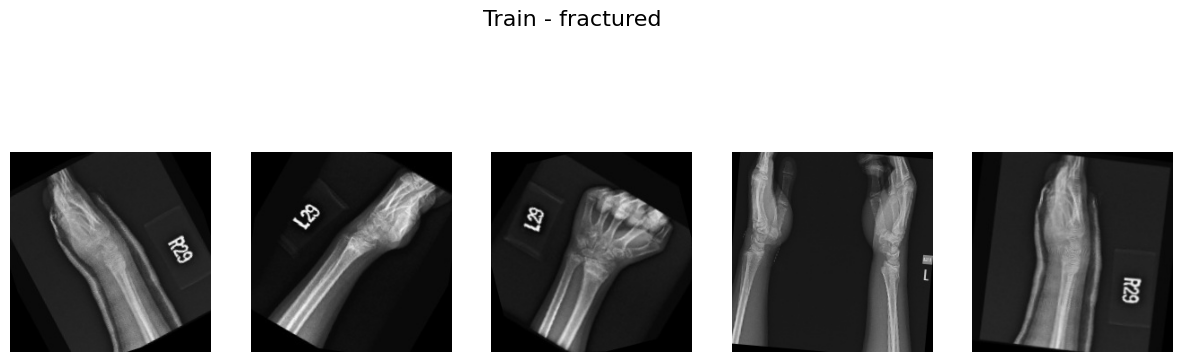

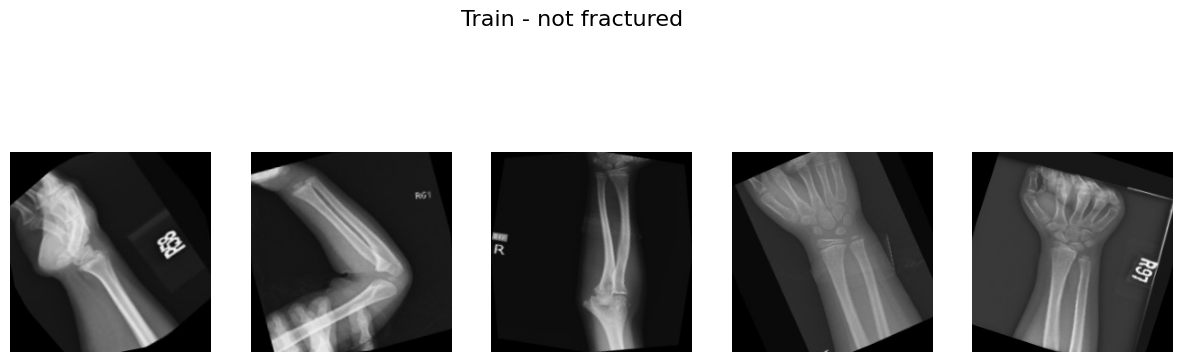

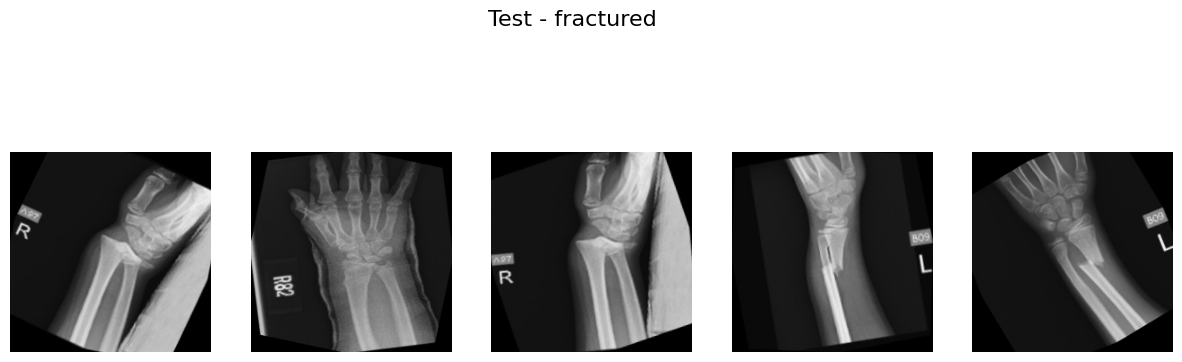

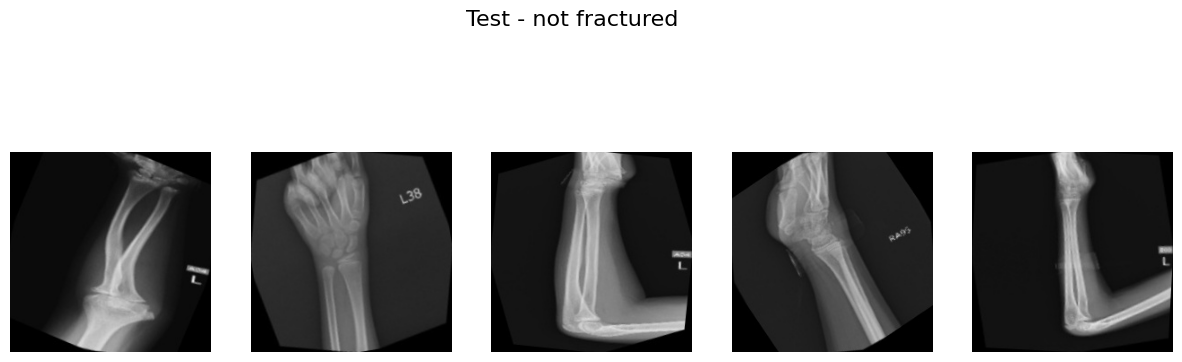

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


dataset_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
categories = ["fractured", "not fractured"]


def display_images(image_paths, title, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis("off")
        else:
            ax.axis("off")
    plt.show()


def get_random_images(data_path, category, num_images=5):
    category_path = os.path.join(data_path, category)
    image_files = os.listdir(category_path)
    return [os.path.join(category_path, random.choice(image_files)) for _ in range(num_images)]


for split, path in [("Train", train_path), ("Test", test_path)]:
    for category in categories:
        images = get_random_images(path, category)
        display_images(images, f"{split} - {category}")


In [15]:
import tensorflow as tf
import os
import numpy as np

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def validate_image(file_path):
    """
    Checks if the image can be decoded successfully.
    """
    try:
        img = tf.io.read_file(file_path)
        tf.image.decode_image(img, channels=1, expand_animations=False)  
        return True
    except Exception as e:
        print(f"Invalid image file skipped: {file_path}")
        return False

def preprocess_image(image, label, augment=False):
    """
    Preprocess a single image and its label.
    """
    image = tf.image.resize(image, (224, 224))  
    image = tf.image.per_image_standardization(image) 
    if augment:
        image = data_augmentation(image)  
    return image, label

def load_filtered_dataset(directory, augment=False):
    """
    Loads and filters a dataset for invalid images, and preprocesses it.
    """
    
    valid_file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if validate_image(file_path):
                    valid_file_paths.append(file_path)
                    labels.append(class_index)

    
    file_paths = tf.constant(valid_file_paths)
    labels = tf.constant(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    
    def decode_and_preprocess(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=1, expand_animations=False)
        return preprocess_image(img, label, augment)

    dataset = dataset.map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset


train_ds = load_filtered_dataset(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train",
    augment=True
)
val_ds = load_filtered_dataset(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
)
test_ds = load_filtered_dataset(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"
)


print("Train Dataset:", train_ds)
print("Validation Dataset:", val_ds)
print("Test Dataset:", test_ds)


Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/26(1).jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/159.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/2.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fractur

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,176,705 (42.64 MB)

 Trainable params: 11,176,705 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9792 - loss: 0.7403 - precision: 0.4839 - recall: 0.4474 - val_accuracy: 0.5905 - val_loss: 68.7512 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.7997 - loss: 7.6840 - precision: 0.3624 - recall: 0.3656 - val_accuracy: 0.5905 - val_loss: 8.1958 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.7703 - loss: 2.0745 - precision: 0.3208 - recall: 0.2739 - val_accuracy: 0.5905 - val_loss: 1.9520 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.2535 - loss: 1.1886 - precision: 0.0389 - recall: 0.0313 - val_accuracy: 0.5905 - val_loss: 0.6847 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 5/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.2989 - loss: 0.7138 - precision: 0.0565 - recall: 0.0461 - val_accuracy: 0.590

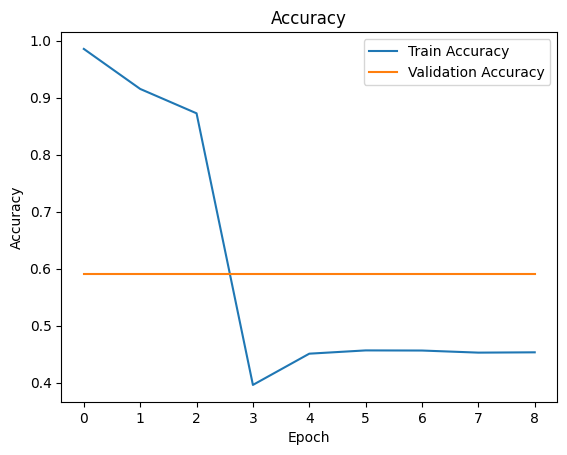

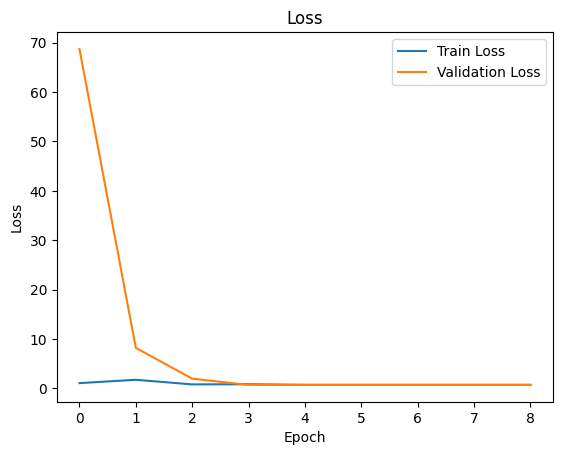

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define the hybrid model
def build_hybrid_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 1)),  # Input layer for grayscale images

        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') 
    ])
    return model


def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


model = build_hybrid_model()
model = compile_model(model)
model.summary()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Plot metrics
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_metrics(history)


**Without augmentation just only random rotation**

In [17]:
import tensorflow as tf
import os
import numpy as np


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
])

def validate_image(file_path):
    """
    Checks if the image can be decoded successfully.
    """
    try:
        img = tf.io.read_file(file_path)
        tf.image.decode_image(img, channels=1, expand_animations=False) 
        return True
    except Exception as e:
        print(f"Invalid image file skipped: {file_path}")
        return False

def preprocess_image(image, label, augment=False):
    """
    Preprocess a single image and its label.
    """
    image = tf.image.resize(image, (224, 224))  
    image = tf.image.per_image_standardization(image) 
    if augment:
        image = data_augmentation(image)  
    return image, label

def load_filtered_dataset(directory, augment=False):
    """
    Loads and filters a dataset for invalid images, and preprocesses it.
    """
    
    valid_file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if validate_image(file_path):
                    valid_file_paths.append(file_path)
                    labels.append(class_index)

    
    file_paths = tf.constant(valid_file_paths)
    labels = tf.constant(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

  
    def decode_and_preprocess(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=1, expand_animations=False)
        return preprocess_image(img, label, augment)

    dataset = dataset.map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset


train_ds = load_filtered_dataset(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train",
    augment=True
)
val_ds = load_filtered_dataset(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
)
test_ds = load_filtered_dataset(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"
)

print("Train Dataset:", train_ds)
print("Validation Dataset:", val_ds)
print("Test Dataset:", test_ds)


Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/26(1).jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/159.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/2.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Invalid image file skipped: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fractur

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,176,705 (42.64 MB)

 Trainable params: 11,176,705 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.9849 - loss: 1.0430 - precision: 0.4897 - recall: 0.4395 - val_accuracy: 0.5905 - val_loss: 32.3639 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.8168 - loss: 4.0366 - precision: 0.3759 - recall: 0.3911 - val_accuracy: 0.5905 - val_loss: 6.9782 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.6617 - loss: 1.7080 - precision: 0.0939 - recall: 0.0279 - val_accuracy: 0.5905 - val_loss: 0.6769 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.3454 - loss: 0.7467 - precision: 0.0655 - recall: 0.0497 - val_accuracy: 0.5905 - val_loss: 0.6771 - val_precision: 0.5905 - val_recall: 1.0000
Epoch 5/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.3071 - loss: 0.7511 - precision: 0.0674 - recall: 0.0580 - val_accuracy: 0.5905 - v

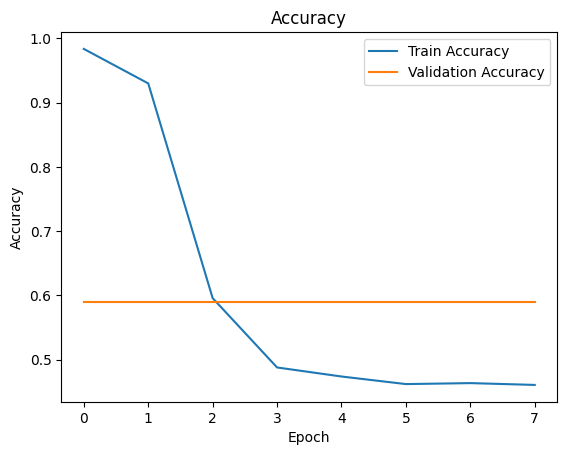

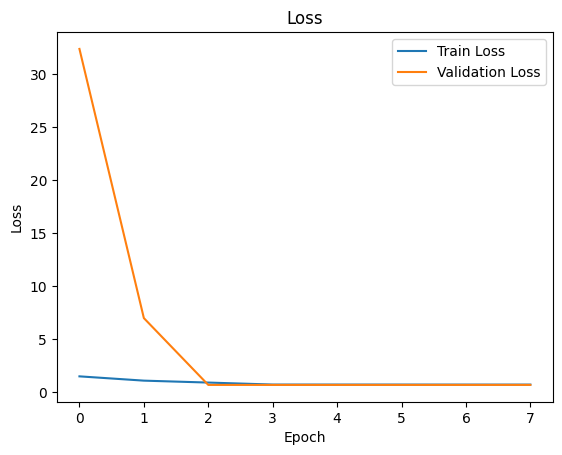

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


def build_hybrid_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 1)),  

        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

       
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  
    ])
    return model


def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


model = build_hybrid_model()
model = compile_model(model)
model.summary()


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping],
    verbose=1
)


test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Plot metrics
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_metrics(history)
